# `CLOUD.jl` - 2D linear advection

In [1]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../../ResearchDocs/ICCFD2022/"
results_path = "../results/advection_dgsem_2D/";

┌ Info: Precompiling CLOUD [fb992021-99c7-4c2d-a14b-5e48ac4045b2]
└ @ Base loading.jl:1342


Define the physical problem

In [2]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=0.0);

Set up a DGSEM scheme of degree `p` with `M` elements

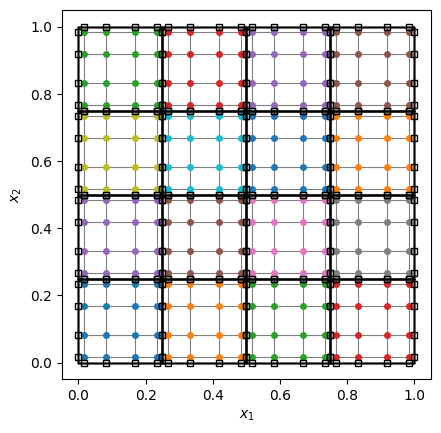

In [3]:
M = 4  # number of elements
p = 3  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGSEM(p), Quad(), N_plot=ceil(Int,50/M), 
    quadrature_rule=LGQuadrature());
spatial_discretization = SpatialDiscretization(
    uniform_periodic_mesh(reference_approximation.reference_element, 
        ((0.0,L),(0.0,L)), (M,M)), reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data,
     WeakConservationForm(), (0.0, T), Lazy(),
     results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf", plot_volume_nodes=true, grid_lines=true)

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [4]:
reset_timer!()
n_s = 50
dt_scale=0.01
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false,
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final")
print_timer()

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            19.8s / 30.4%           5.79GiB / 65.9%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 rhs!                   15.9k    6.01s   100%   378μs   3.82GiB  100%    252KiB
   eval residual         254k    2.83s  47.0%  11.1μs   1.58GiB  41.3%  6.50KiB
     facet terms         254k    1.08s  17.9%  4.24μs    536MiB  13.7%  2.16KiB
     volume terms        254k    921ms  15.3%  3.62μs    912MiB  23.3%  3.68KiB
     mass matrix solve   254k   51.2ms  0.85%   201ns   50.4MiB  1.29%     208B
   extrapolate solu...   254k    1.13s  18.8%  4.45μs    660MiB  16.9%  2.66KiB
   eval numerical flux   254k    453ms 

Visualize the solution

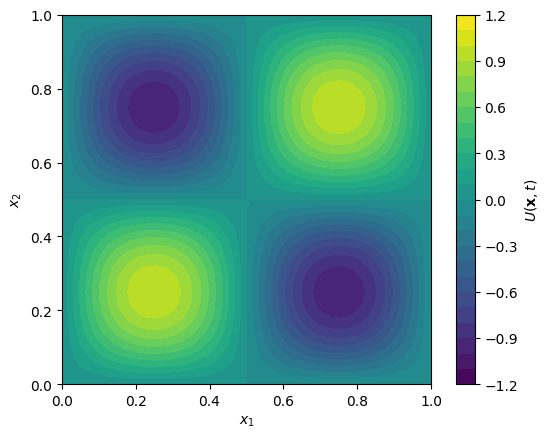

In [5]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

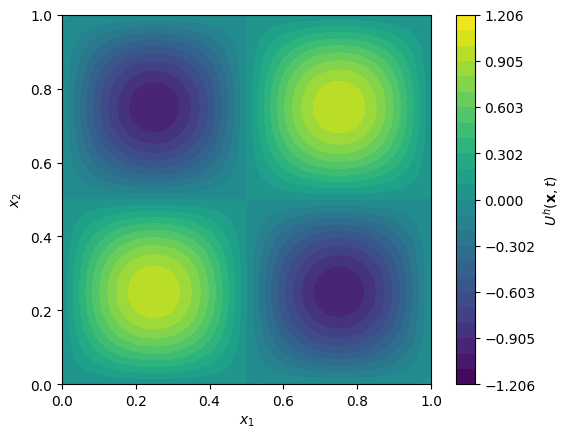

In [6]:
visualize(last(sol.u),plotter, "approx.pdf", contours=25, 
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [7]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.0012684801830541964]
Conservation (initial/final/diff):
[-2.0816681711721685e-17][2.7755575615628914e-17][4.85722573273506e-17]
Energy (initial/final/diff):
[0.24999999999999994][0.24999999999999437][-5.578870698741412e-15]
